In [16]:
import re
import random
import pandas as pd
import hashlib

In [17]:
with open('certcards2.txt', mode='r', encoding='utf8') as f:
    all_cards = f.read()
    
card_split_pattern = r'\n\n\n\d+\n'
all_cards = re.split(card_split_pattern, all_cards)
# Use re.DOTALL to allow . to match newline characters
card_pattern = re.compile(r'(.+?)\n([\s\S]+)', re.DOTALL)
cards = [(match.group(1), match.group(2)) for cstring in all_cards if (match := re.search(card_pattern, cstring))]

# removing the cards that have no content and trimming
cards = [(subject, stripped_content) for subject, content in cards if len(stripped_content := content.strip()) > 5]

def hash_string_md5(s):
    """
    Hashes a string using MD5 and returns a truncated hash for efficiency.

    Parameters:
    - s (str): The input string to hash.

    Returns:
    - str: The truncated hexadecimal hash string.
    """
    if pd.isnull(s):
        return None  # Handle NaN values gracefully
    return hashlib.md5(s.encode('utf-8')).hexdigest()


def remake_card_document(existing_cards: pd.DataFrame, filename: str='certcards2.txt'):
    with open(filename, mode='w', encoding='utf8') as f:
        i = 1
        for _, row in existing_cards.iterrows():
            f.write('\n'*6)
            f.write(str(i)+'\n')  
            f.write(row['head']+'\n')
            f.write(row['body'])
            i+=1
    print(F"Cards found: {existing_cards.shape[0]}")
    print(F"Total card age: {abs(existing_cards['age'].sum()):.2f}")


existing_cards = pd.DataFrame(cards, columns=['head', 'body'])


# existing_cards['age'] = [random.random() for _ in existing_cards.index]
existing_cards['hash'] = existing_cards['body'].apply(hash_string_md5)
existing_cards

card_ages = pd.read_json('card_ages.json')
card_ages = card_ages.drop_duplicates(subset=['hash'], keep='first')

cards_to_age = pd.merge(
    left=existing_cards,
    right=card_ages[['hash', 'age']],
    left_on='hash', right_on='hash',
    how='left'
)

cards_to_age['head'] = cards_to_age['head'].str.strip()

# if cards_to_age['age'].mean() > 80: age_factor = .5
# else: age_factor = 1

cards_to_age['age'] = cards_to_age['age'].fillna(0)
# cards_to_age['age'] = cards_to_age['age'] * age_factor
cards_to_age['age'] = cards_to_age['age'] + [random.expovariate(.5) for _ in cards_to_age.index]
# cards_to_age['age'] = cards_to_age['age'] * [random.expovariate(1) for _ in cards_to_age.index]
if cards_to_age['age'].mean() > 80: 
    cards_to_age['age'] = cards_to_age['age'] * [random.expovariate(1.3) for _ in cards_to_age.index]

# Adding priority age growth to cards for upcoming certifications
priority_headers = ['Azure Developer Associate']
priority_cards_mask = cards_to_age['head'].isin(priority_headers)
cards_to_age.loc[priority_cards_mask, 'age'] = cards_to_age.loc[priority_cards_mask, 'age'] * 1.075

cards_to_age = cards_to_age.drop_duplicates(subset=['hash'], keep='first')

cards_to_age['subject_mean_age'] = cards_to_age.groupby('head')['age'].transform('mean')
cards_to_age['subject_highest_age'] = cards_to_age.groupby('head')['age'].transform('max')
cards_to_age['subject_age_sum'] = cards_to_age.groupby('head')['age'].transform('sum')
cards_to_age['head_random_roll'] = cards_to_age.groupby('head')['head'].transform(lambda x: random.random())
cards_to_age['head_count'] = cards_to_age.groupby('head')['head'].transform("count")


cards_to_age.sort_values('hash')[['age', 'head', 'hash']].to_json('card_ages.json', indent=2)

existing_cards = cards_to_age

In [18]:
stats = existing_cards.groupby('head').agg({'age': ['sum', 'mean', 'max'], 'head': 'count'}).sort_values(('age', 'sum'))
stats.columns = stats.columns.to_flat_index()
stats.columns = ['_'.join(col).strip() for col in stats.columns]
stats.index.name = None
stats

,age_sum,age_mean,age_max,head_count
OAuth 2.0 RFC6749,361.760706,32.887337,121.618572,11
CCH Tax Forms Project,369.468027,17.593716,85.259789,21
pfSense,384.618280,32.051523,125.835560,12
Terraform,452.294960,75.382493,272.968639,6
Accounting,483.694653,28.452627,84.285735,17
Python + Oauth2.0,622.656546,27.072024,97.966446,23
Active Directory and Azure Files,723.419287,19.551873,60.481001,37
FSLogix,807.329373,67.277448,151.560872,12
Azure Functions + PP365,849.972841,94.441427,376.490576,9
"The Starless Crown, Rollins",879.467134,32.572857,110.830039,27


# Histogram

sum of ages: ~43935.15


<Axes: >

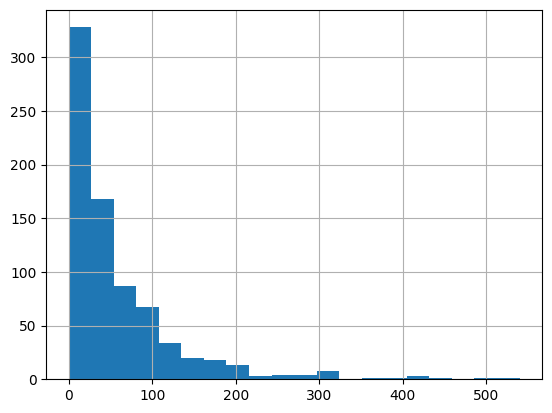

In [19]:
print(f"sum of ages: ~{existing_cards['age'].sum(0):.2f}")
existing_cards['age'].hist(bins=20)

sum of ages: ~43935.15


<Axes: >

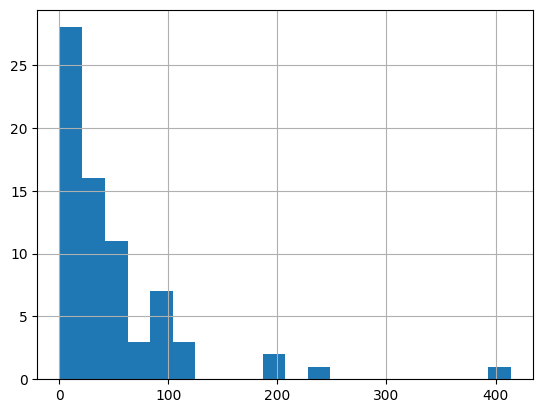

In [20]:
print(f"sum of ages: ~{existing_cards['age'].sum(0):.2f}")
existing_cards[existing_cards['head']=='Python']['age'].hist(bins=20)

# Completely Random Shuffle

In [21]:
# existing_cards = existing_cards.sample(frac=1)
# remake_card_document(filename='certcards2.txt', existing_cards = existing_cards)

# Age Sort

In [22]:
# existing_cards = existing_cards.sort_values('age', ascending=False)
# remake_card_document(filename='certcards2.txt', existing_cards=existing_cards)
# existing_cards.head(10)

# N-fold shuffle


## Age Sum

In [23]:
# n=3
# m=existing_cards.shape[0]//100
# existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
# existing_cards['n_fold'] = existing_cards['count'] % n

# existing_cards['subject_age_sum'] = existing_cards['subject_age_sum'] *-1
# existing_cards['age'] = existing_cards['age'] *-1
# existing_cards.sort_values(['n_fold', 'subject_age_sum', 'age'], inplace=True)

# remake_card_document(existing_cards=existing_cards)
# existing_cards.head(10)


## Age Mean

In [24]:
# n=3
# existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
# existing_cards['n_fold'] = existing_cards['count'] % n

# existing_cards['subject_mean_age'] = existing_cards['subject_mean_age'] *-1
# existing_cards['age'] = existing_cards['age'] *-1
# existing_cards.sort_values(['n_fold', 'subject_mean_age', 'age'], inplace=True)
# remake_card_document(existing_cards=existing_cards)

# existing_cards.head(10)

## Age Max

In [25]:
# n = 3
# existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
# existing_cards['n_fold'] = existing_cards['count'] // 5

# if existing_cards['age'].sum() > 0:
#     existing_cards['subject_highest_age'] = existing_cards['subject_highest_age'] *-1
#     existing_cards['neg_age'] = existing_cards['age'] *-1
# existing_cards.sort_values(['n_fold', 'subject_highest_age', 'neg_age'], inplace=True)
# # existing_cards.sort_values(['age'], inplace=True)

# remake_card_document(existing_cards=existing_cards)
# existing_cards.head(10)


## Card Count

In [26]:
n=4
# existing_cards['frequency']  = existing_cards.groupby('head').transform('count')['body']
existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
existing_cards['n_fold'] = existing_cards['count'] // n

if existing_cards['age'].sum() > 0:
    # existing_cards['neg_subject_highest_age'] = existing_cards['subject_highest_age'] *-1
    existing_cards['neg_age'] = existing_cards['age'] *-1
    existing_cards['subject_highest_age'] *= -1
existing_cards.sort_values(['n_fold', 'head_count', 'subject_highest_age', 'neg_age'], inplace=True)
remake_card_document(existing_cards=existing_cards)

existing_cards.head(10)

Cards found: 762
Total card age: 43935.15


,head,body,hash,age,subject_mean_age,subject_highest_age,subject_age_sum,head_random_roll,head_count,count,n_fold,neg_age
0,Terraform,Variable References:\nRefer to variables using...,d9cdbdc6137b846a17caa27cd11b8c46,272.968639,75.382493,-272.968639,452.294960,0.100220,6,0,0,-272.968639
3,Terraform,Debugging Tips:\nCheck Quotes: Ensure that you...,bb1942142b9c1c162db7e0ccfdafb8d5,73.679089,75.382493,-272.968639,452.294960,0.100220,6,1,0,-73.679089
1,Terraform,Expressions and Operators:\nDefinition: Terraf...,3a18bd16fd51306a7e6c69ff09751d2b,45.561083,75.382493,-272.968639,452.294960,0.100220,6,2,0,-45.561083
4,Terraform,Dynamic Blocks:\nDefinition: Allow you to cons...,28763e7ddcf4cb0a2802e902b77a7035,25.664537,75.382493,-272.968639,452.294960,0.100220,6,3,0,-25.664537
7,Azure Functions + PP365,Async Programming (Asyncio)\nA programming par...,84ef9036376cd6bdf68c3b08fc358303,376.490576,94.441427,-376.490576,849.972841,0.732830,9,0,0,-376.490576
12,Azure Functions + PP365,HTTP Triggers\nA type of function trigger that...,b9e42ab2e8e591023bd1aa43b8509bfc,149.126809,94.441427,-376.490576,849.972841,0.732830,9,1,0,-149.126809
14,Azure Functions + PP365,XMLHttpRequest vs. Fetch API\nBoth are JavaScr...,ea615479abd9b96c554796c14460197c,112.323410,94.441427,-376.490576,849.972841,0.732830,9,2,0,-112.323410
10,Azure Functions + PP365,local.settings.json\nA configuration file used...,456803710150f60b5b54a409cf084224,69.129025,94.441427,-376.490576,849.972841,0.732830,9,3,0,-69.129025
22,OAuth 2.0 RFC6749,The authorization code is obtained by using an...,36fe56d0e538d035243da571083eb1d3,121.618572,32.887337,-121.618572,361.760706,0.328648,11,0,0,-121.618572
245,OAuth 2.0 RFC6749,OAuth defines four roles:\n\n resource owner...,4c6817097b7ded45a81ded15e6c31b9a,98.773038,32.887337,-121.618572,361.760706,0.328648,11,1,0,-98.773038



## Random

In [27]:
# n = 3
# existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
# existing_cards['n_fold'] = existing_cards['count'] % n
# existing_cards['age'] *= -1
# existing_cards.sort_values(['n_fold', 'head_random_roll', 'age'], inplace=True)
# remake_card_document(existing_cards=existing_cards)
# existing_cards.head(10)

In [28]:
existing_cards.head(10)['age'].sum()

np.float64(1345.3347784821012)

In [29]:
asc = existing_cards.age.sum() < 0

existing_cards.sort_values('age', ascending=asc).head(10)

,head,body,hash,age,subject_mean_age,subject_highest_age,subject_age_sum,head_random_roll,head_count,count,n_fold,neg_age
62,C# Basics,Events use delegates to provide a way for a cl...,100ad5855cfede73f888d3e9485c7b26,539.633893,109.527827,-539.633893,2300.084377,0.129852,21,0,0,-539.633893
258,C# Basics,Lambda expressions provide a concise way to re...,059a0c05a32a63a831c1c5515f10e488,486.265268,109.527827,-539.633893,2300.084377,0.129852,21,1,0,-486.265268
194,Vocab,"Well of Lost Plots, Fforde\nInsouciance\nnoun ...",ae15401d43ed91aa235054578c87ffd1,452.738235,92.086947,-452.738235,4051.825684,0.441859,44,0,0,-452.738235
178,PnP PowerShell,Invoke-WebRequest (Microsoft.PowerShell.Utilit...,6b09af70ff47a16ac9835232449e7bf9,417.135049,79.869085,-417.135049,3035.025217,0.644317,38,0,0,-417.135049
239,Python,Q:\nWhat does the .with_suffix(new_suffix) met...,21ca55fe0eb03e620bb7df636fd19618,413.938120,48.566202,-413.938120,3496.766573,0.633871,72,0,0,-413.938120
92,Asynchronous Python,Blocking Code\nCode like time.sleep() that hal...,86b1b1b8d6f8d43714c7e33ba4510bda,412.411183,74.652926,-412.411183,1717.017300,0.284646,23,0,0,-412.411183
391,Vocab,"Red Side Story, FForde\nOsculation\nPronunciat...",c0228d8d87eacb74c922d616f38c5d9b,400.644878,92.086947,-452.738235,4051.825684,0.441859,44,1,0,-400.644878
7,Azure Functions + PP365,Async Programming (Asyncio)\nA programming par...,84ef9036376cd6bdf68c3b08fc358303,376.490576,94.441427,-376.490576,849.972841,0.732830,9,0,0,-376.490576
75,VMWare,Storage vMotion\n\nThe ability to migrate virt...,2e3e71c9de5d2efac881521e2e5b348d,321.413824,108.809060,-321.413824,2393.799323,0.005046,22,0,0,-321.413824
518,PnP PowerShell,Delegated Permissions\nPermissions granted to ...,53d0d302c9f3f7d4b92f4b022a587641,319.057844,79.869085,-417.135049,3035.025217,0.644317,38,1,0,-319.057844


In [30]:
existing_cards['age'].mean()

np.float64(57.65767815724441)